In [4]:

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [05:27<00:00, 151MB/s]
100% 28.6G/28.6G [05:27<00:00, 93.7MB/s]


In [5]:
!unzip -q airbus-ship-detection -d airbus-ship-detection

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import pyplot
from keras.models import Model
from keras.layers import Input, Concatenate, Activation
from keras.layers import  UpSampling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D


TRAIN_V2='airbus-ship-detection/train_v2/'
SEGMENTATION ='airbus-ship-detection/train_ship_segmentations_v2.csv'

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def prepare_dataset():
    
    train_v2 = os.listdir(TRAIN_V2)
    print("Len train_v2:",len(train_v2))
    train_csv = pd.read_csv(SEGMENTATION)
    train_csv['withShip'] = ~train_csv['EncodedPixels'].isnull()
    print(train_csv.head())
   
    # Example data
    ImageId='0a2c6480e.jpg'
    img = imread(TRAIN_V2 + ImageId)
    img_masks = train_csv.loc[train_csv['ImageId'] == ImageId, 'EncodedPixels'].tolist()
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask)
    
    fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(all_masks)
    axarr[2].imshow(img)
    axarr[2].imshow(all_masks, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()

    # Image Ship Count Distribution
    figdf = train_csv.fillna(0).groupby('ImageId').sum()['withShip'].value_counts()
    plt.bar(figdf.index, figdf.values)
    plt.xlabel('Ship Count', fontsize=14)
    plt.ylabel('Images counts', fontsize=14)
    plt.title('Image Ship Count Distribution', fontsize=18)
    plt.show()


    # Balance the data
    DROP_NO_SHIP_FRACTION = 0.8
    bal_train_csv=train_csv.set_index('ImageId').drop(
        train_csv.loc[
            train_csv.isna().any(axis=1),
            'ImageId'
        ]).reset_index()
    
    bal_train_csv=bal_train_csv.sample( frac = DROP_NO_SHIP_FRACTION , random_state=1)
    

    #Balanced Dataset w/o Ship
    figdf=bal_train_csv.groupby('ImageId').count()['withShip'].value_counts()
    plt.bar(figdf.index, figdf.values)
    plt.xlabel('Ship Count', fontsize=14)
    plt.ylabel('Images counts', fontsize=14)
    plt.title('Balanced Dataset w/o Ship', fontsize=18)
    plt.show()
    

    # Split train and validate data
    b_train_csv, b_valid_csv = train_test_split(bal_train_csv, test_size = 0.3)

    return b_train_csv, b_valid_csv 

# Keras data generator
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

# Hyper parameters
IMG_SCALING = (3,3)

def keras_generator(gen_df, batch_size=4):
    all_batches = list(gen_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(TRAIN_V2, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0).astype(np.float)
                
                out_rgb, out_mask=[], []





Len train_v2: 192556
         ImageId                                      EncodedPixels  withShip
0  00003e153.jpg                                                NaN     False
1  0001124c7.jpg                                                NaN     False
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      True
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      True
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      True


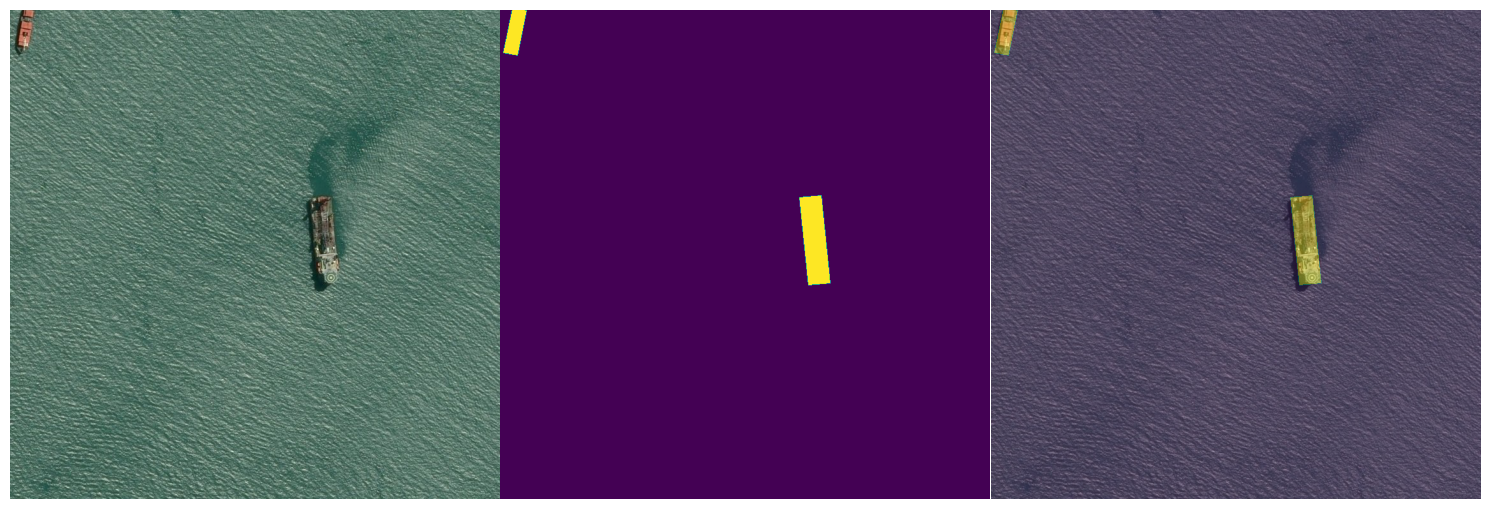

<ipython-input-7-5484fa4bc68c>:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  figdf = train_csv.fillna(0).groupby('ImageId').sum()['withShip'].value_counts()


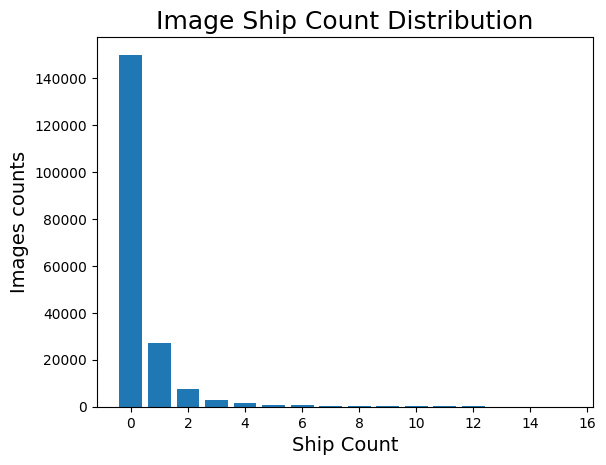

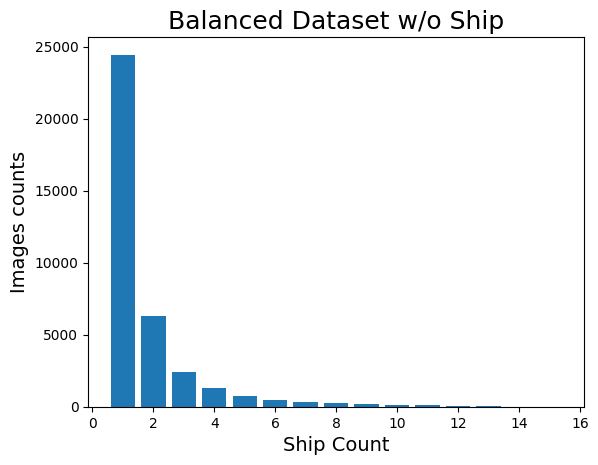

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 8)  224         ['input_7[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 256, 8)  584         ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 8)  0          ['conv2d_21[0][0]']        

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-12-51fc41e92362>:81: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = unet_model.fit_generator(keras_generator(train_csv),


Epoch 1/10


<ipython-input-7-5484fa4bc68c>:127: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0).astype(np.float)


100/100 [==============================] - ETA: 0s - loss: 5.4024 - binary_accuracy: 0.9781

<ipython-input-7-5484fa4bc68c>:127: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0).astype(np.float)


100/100 [==============================] - 206s 2s/step - loss: 5.4024 - binary_accuracy: 0.9781 - val_loss: 4.3691 - val_binary_accuracy: 0.9677
Epoch 2/10
100/100 [==============================] - 210s 2s/step - loss: 2.0521 - binary_accuracy: 0.9849 - val_loss: 2.1460 - val_binary_accuracy: 0.9707
Epoch 3/10
100/100 [==============================] - 188s 2s/step - loss: 1.3690 - binary_accuracy: 0.9885 - val_loss: 1.3354 - val_binary_accuracy: 0.9900
Epoch 4/10
100/100 [==============================] - 190s 2s/step - loss: 1.4773 - binary_accuracy: 0.9915 - val_loss: 1.5075 - val_binary_accuracy: 0.9935
Epoch 5/10
100/100 [==============================] - 193s 2s/step - loss: 1.3076 - binary_accuracy: 0.9908 - val_loss: 1.6107 - val_binary_accuracy: 0.9932
Epoch 6/10
100/100 [==============================] - 184s 2s/step - loss: 1.3439 - binary_accuracy: 0.9896 - val_loss: 1.7962 - val_binary_accuracy: 0.9948
Epoch 7/10
100/100 [==============================] - 184s 2s/step - 

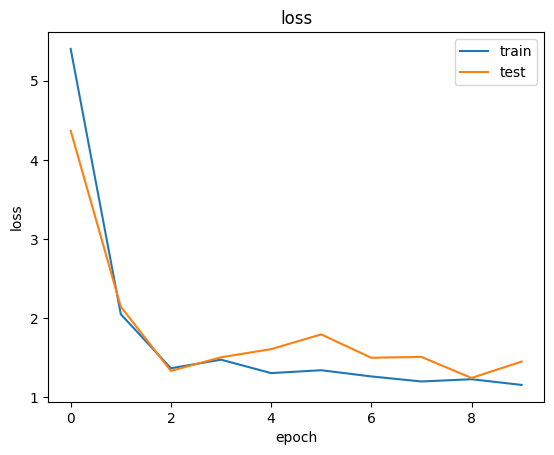

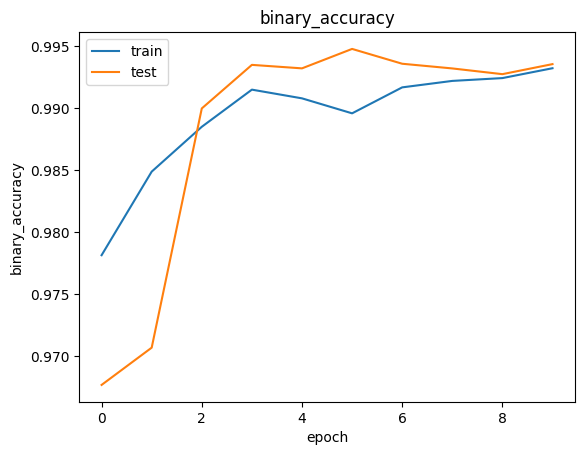

In [12]:

def build_model():
    


    # Design the Model

    
    
    img = layers.Input((256, 256, 3))

    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (img)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = layers.MaxPooling2D((2, 2)) (c1)

    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = layers.MaxPooling2D((2, 2)) (c2)

    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)

    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = layers.UpSampling2D((2, 2)) (c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = layers.UpSampling2D((2, 2)) (c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = layers.UpSampling2D((2, 2)) (c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = layers.UpSampling2D((2, 2)) (c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    o = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same') (c9)

    unet_model = models.Model(inputs=[img], outputs=[o])
        
    unet_model.summary()
    return unet_model


def dice_coeff(target, pred):
  # target__==target
  smooth = 1.0
  intersection = K.sum(target * pred, axis=[1,2,3])
  union = K.sum(target, axis=[1,2,3]) + K.sum(pred, axis=[1,2,3])
  return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
  # return ((2*((pred*target).sum()))+smooth) / (pred.sum()+target.sum()+smooth)

def loss(target, pred):
  bce = binary_crossentropy(target, pred)
  dice_loss = 1-dice_coeff(target, pred)
  return bce-tf.math.log(1-dice_loss)

def train_model(unet_model, train_csv, valid_csv, steps_per_epoch, epochs,validation_steps): 
    # Compile the model
    adam = tf.keras.optimizers.legacy.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
    unet_model.compile(optimizer='adam', loss=loss, metrics=[ 'binary_accuracy'])
    #mc = ModelCheckpoint('best_model.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
    
    # Train the model
    history = unet_model.fit_generator(keras_generator(train_csv),
                                            steps_per_epoch=steps_per_epoch, 
                                            epochs=epochs, 
                                            validation_data=keras_generator(valid_csv),
                                            validation_steps=validation_steps)
   
    return history


def evaluate_model(history):
    # Plotting Results  
    fig = plt.figure()
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend()
    pyplot.show()
    
    fig = plt.figure()
    pyplot.plot(history.history['binary_accuracy'], label='train')
    pyplot.plot(history.history['val_binary_accuracy'], label='test')
    pyplot.title('binary_accuracy')
    pyplot.ylabel('binary_accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend()
    pyplot.show()

def save_model(model):
    # Save the model
    model.save_weights('unet_model_w.h5')
    model.save('unet_model.h5')

def main():
    # Set hyperparameter
    steps_per_epoch=100
    epochs = 10
    validation_steps=50

    # Prepare the dataset
    train_csv, valid_csv  = prepare_dataset()

    #Build the model

    model = build_model()
    
    

    #Train the model
    history=train_model(model, train_csv, valid_csv,  steps_per_epoch, epochs,validation_steps)

    # Evaluate the model
    evaluate_model(history)

    #Save the model
    save_model(model)



if __name__ == '__main__':
    main()
